# <center> Deep Q Network </center>#

## CartPole Environment

We implement a Deep Q Netowrk to play the CartPole game: balance the pole on the cart. 

CartPole gym environment is made up the following:

**Observation (State)**:


|Num	|Observation	|Min	|Max|
|:------:|:------------|---------:|-----:|
|0	|Cart Position	|-2.4|	2.4|
|1	|Cart Velocity|	-Inf	|Inf|
|2	|Pole Angle	|~ -41.8°|	~ 41.8°|
|3	|Pole Velocity At Tip	|-Inf	|Inf|

**Actions**

|Num	|Action   |
|:------:|:------------|
|0	Push |cart to the left|
|1	Push |cart to the right|


Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

**Reward**

Reward is 1 for every step taken, including the termination step.

## Deep Learning Model

Given a state as an input, we use a sequence neural network to predict the Q-value for each possible state (state-action values)

For Deep Q Network, the loss is the difference between the predicted Q value and the expected Q value. Then `MSE` is the loss function used.

In [ ]:
def _build_model(self):
    
    # Neural Net for Deep-Q learning Model
    model = Sequential()
    # input is a state, so the input dimension is the state shape
    model.add(Dense(24, input_dim=self.state_size, activation='relu'))  
    model.add(Dense(24, activation='relu'))
    
    # The output dimension is the number of actions
    # Q values can be positive or negative. So activation function is linear
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
    return model

## Train the deep neural network by experience replay

OpenAI Gym environments are structured around two main parts: an observation space (i.e. state) and an action space. We observe the former from the environment and use that to determine how best to update it through an action, i.e. based on the current state of the pole (observation), determine whether to move the cart left or right (action).

The first part of any machine learning problem is gathering the data, and this one is no different. Luckily, OpenAI’s gym environment provides a very straightforward way of gathering data: we can essentially just run through the simulation many times and take random steps every time. 

The training samples, denoted as tuples of $(s, a, r, s', done)$, are collected through the `memorize` function.

In [ ]:
# Save experience as samples
# done : whether end game is reached
def memorize(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

During training, we `replay` the experiences $(s, a, r, s')$ collected:
- Predict Q value of $Q_{predicted}(s, a)$ using the deep neural network
- Calculate the target Q value of of $(s, a)$ as: $Q_{target}(s, a) = r + \gamma * \max_{a'}{Q(s',a')}$, where $Q(s',a')$ is predicted with the deep learning network. 
- Finally, the loss is measured as $ MSE~[Q_{predicted}(s, a), Q_{target}(s, a)]$, the difference between the `predicted Q value` and `target Q value`. 

In [ ]:
# Sample experiences and train the deep learning model following mini-batch
def replay(self, batch_size):
    
    # sample a minibatch
    minibatch = random.sample(self.memory, batch_size)
    
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target = (reward + self.gamma *
                      np.amax(self.model.predict(next_state)[0]))
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
        
        # apply smaller epsilon to reduce exploration
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay


## Take an action

The deep neural network predicts the Q value for all actions given an input state. Then the action with the max Q value is selected. Meanwhile, $\epsilon$-greedy is implemented to choose a random action for exploration

In [ ]:
def act(self, state):
    # e-greedy 
    if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
    
    act_values = self.model.predict(state)
    # returns action with the max Q value
    return np.argmax(act_values[0])  


## Put everything together

In [3]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        '''action network: mapping input state to Q(s,a)
        Return:
            An network approximate Q(s,a)
        '''
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        '''take state as input for action network to predict next action
        Return:
            an integer(index of action)
        '''
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action with highest Q value

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state) # an array of n element-array [[a,b]] n is dimension of action space
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)




In [4]:
if __name__ == "__main__":

    # initialization for agent and environment
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0] # given from environment
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")

    # hyper-parameter
    done = False
    batch_size = 32
    history = []
    EPISODES = 100
    
    for e in range(EPISODES): # one episode is M tradings in N trading years
        
        # initialize state
        state = env.reset()
        state = np.reshape(state, [1, state_size]) # an array containing only one array [[a,b,c,d]]
        rewards = 0
        
        for time in range(500): # need to be modified for time range within a year
            # env.render()
            
            # take an action
            action = agent.act(state)
            
            # environment responds to the action and return new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # record reward. If done (i.e. the pole falls down, the reward is -10)
            reward = reward if not done else -10 # ending reward should be the same as before
            rewards += reward
            
            # reshape state since the neural network expects an array with rank 2 (can be reshaped within env)
            next_state = np.reshape(next_state, [1, state_size]) # an 1 x n 2d array
            
            # record the experience for replay
            agent.memorize(state, action, reward, next_state, done) # record every trading 
            
            # transit to next state
            state = next_state
            
            # determine if the game is over or not
            if done:
                break
                
            # if there are enough experiences accumulated, replay to train the network    
            if len(agent.memory) > batch_size: # batch_size = 2 to make agent learn for every 3 trading events
                agent.replay(batch_size)
                
        print("episode: {}/{}, score: {}, e: {:.2}, rewards: {}"
                      .format(e, EPISODES, time, agent.epsilon, rewards))
        
        history.append([e, time, agent.epsilon, rewards])

episode: 0/100, score: 36, e: 0.98, rewards: 26.0


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(history, columns =["episode", "total_time","epsilon",'reward'])
df.set_index("episode")
df['reward'].rolling(5).mean().plot(figsize=(15,5))
plt.show

df[["epsilon"]].plot(figsize=(15,5))
plt.show

# Test

In [5]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

In [21]:
test_state = env.reset()
test_act = agent.act(test_state)
env.step(test_act)

(array([ 0.03900202, -0.19094466, -0.04336792,  0.25769242]), 1.0, False, {})

## Test of trading env

In [1]:
import sys
module_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/'
sys.path.append(module_path)
from environment import market_envrionment
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
env_test = market_envrionment()

In [5]:
# initialization for agent and environment
env = market_envrionment()
state_size = env.observation_space[0] # given from environment
action_size = env.action_space.shape[0]
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")

# hyper-parameter
done = False
batch_size = 5
history = []
EPISODES = 100

In [6]:
# initialize state
state = env.reset()
state = np.reshape(state, [1, state_size]) # an array containing only one array [[a,b,c,d]]
rewards = 0

In [29]:
# take an action
action = agent.act(state)

# environment responds to the action and return new state and reward
next_state, reward, done = env.step(action)

# record reward
rewards += reward

# reshape state since the neural network expects an array with rank 2 (can be reshaped within env)
next_state = np.reshape(next_state, [1, state_size]) # an 1 x n 2d array

# record the experience for replay
agent.memorize(state, action, reward, next_state, done) # record every trading 

# transit to next state
state = next_state

# determine if the game is over or not
if done:
    print("end")
    
# if there are enough experiences accumulated, replay to train the network    
if len(agent.memory) > batch_size: # batch_size = 2 to make agent learn for every 3 trading events
    agent.replay(batch_size)

end


In [32]:
# initialization for agent and environment
env = market_envrionment()
state_size = env.observation_space[0] # given from environment
action_size = env.action_space.shape[0]
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")

# hyper-parameter
done = False
batch_size = 5
history = []
EPISODES = 100

for e in tqdm(range(EPISODES)): # one episode is M trading years in a period
    
    # initialize state
    state = env.reset()
    state = np.reshape(state, [1, state_size]) # an array containing only one array [[a,b,c,d]]
    rewards = 0
    
    for time in range(17): # how many years in a training period

        # take an action
        action = agent.act(state)
        
        # environment responds to the action and return new state and reward
        next_state, reward, done = env.step(action)
        
        # record reward
        rewards += reward
        
        # reshape state since the neural network expects an array with rank 2 (can be reshaped within env)
        next_state = np.reshape(next_state, [1, state_size]) # an 1 x n 2d array
        
        # record the experience for replay
        agent.memorize(state, action, reward, next_state, done) # record every trading 
        
        # transit to next state
        state = next_state
        
        # determine if the game is over or not
        if done:
            break
            
        # if there are enough experiences accumulated, replay to train the network    
        if len(agent.memory) > batch_size: # batch_size = 2 to make agent learn for every 3 trading events
            agent.replay(batch_size)
            
    print("episode: {}/{}, e: {:.2}, rewards: {:.5}"
                    .format(e, EPISODES, agent.epsilon, rewards))
    
    history.append([e, time, agent.epsilon, rewards])

100%|██████████| 100/100 [10:22<00:00,  6.23s/it]episode: 99/100, e: 0.001, rewards: 1.6535



<function matplotlib.pyplot.show(close=None, block=None)>

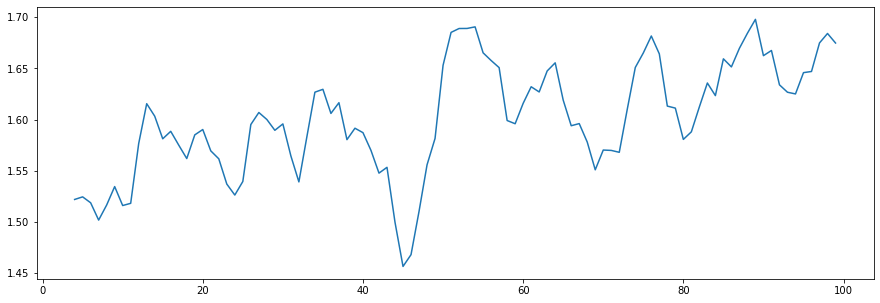

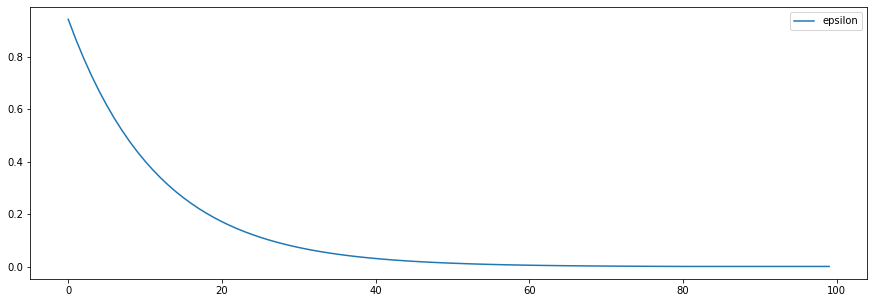

In [34]:
df = pd.DataFrame(history, columns =["episode", "total_time","epsilon",'reward'])
df.set_index("episode")
df['reward'].rolling(5).mean().plot(figsize=(15,5))
plt.show

df[["epsilon"]].plot(figsize=(15,5))
plt.show

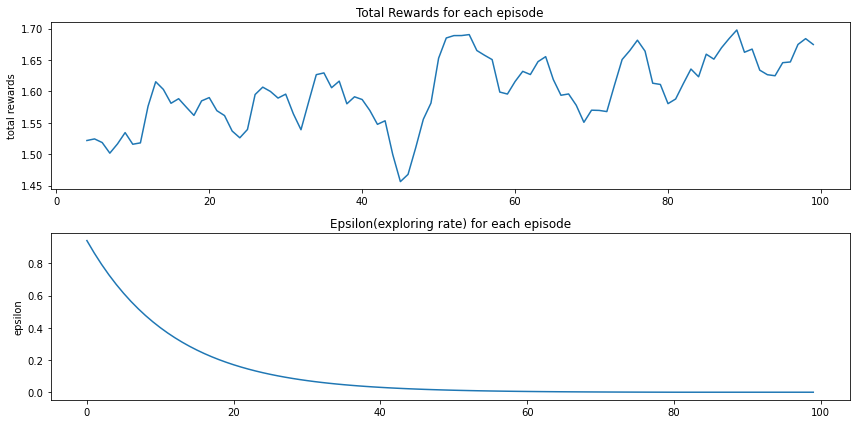

In [71]:
df = pd.DataFrame(history, columns =["episode", "total_time","epsilon",'reward'])
df.set_index("episode")
figs, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

axs[0].set_title('Total Rewards for each episode')
axs[0].plot(df.index, df['reward'].rolling(5).mean())
axs[0].set_ylabel('total rewards')

axs[1].set_title('Epsilon(exploring rate) for each episode')
axs[1].plot(df.index, df['epsilon'])
axs[1].set_ylabel('epsilon')

plt.tight_layout()
# figs.savefig('picture/response_variable.jpg')
plt.show()

In [68]:
df.index

RangeIndex(start=0, stop=100, step=1)

**ENV:**
- self.observation_space  {need modification for both agent and env}
- self.action_space (np.array) {need modification for both agent and env}
- step {return a four elements tuple (next_state(a 2-d array \[[a,b,c]\]), reward, done, )}
- reset {return np.array of state/ and reset everything in env}

**Agent:**
- action_size

**Simulation**:
- reward: ending reward should be the same as before